In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import os
import json


#plot Options
import matplotlib as mpl
font = {#'family' : 'normal','weight' : 'bold',
        'size'   : 16
        #,'serif':['Helvetica']
        }
mpl.rc('font', **font)
mpl.rcParams['figure.dpi'] = 400

###
####constants
degree = np.pi/180 # convert form rad to degree


Attempt to model that the Capillary gets obscured by its housing 
in parts and not all at once

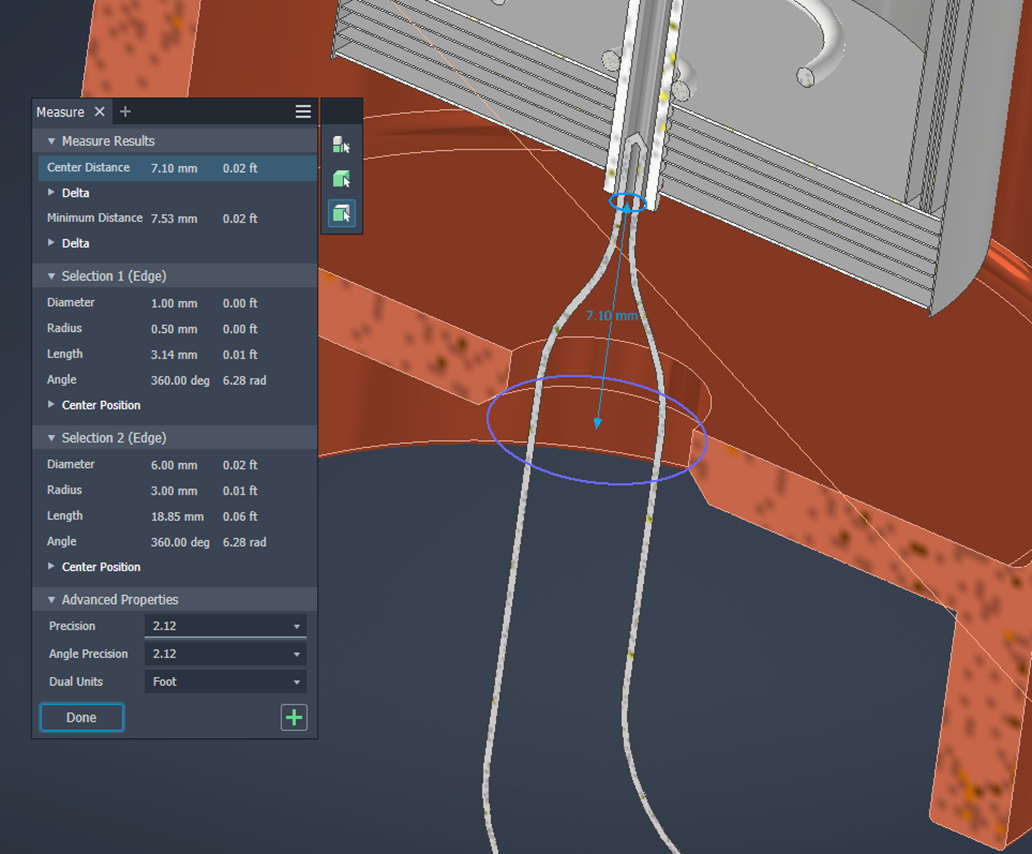

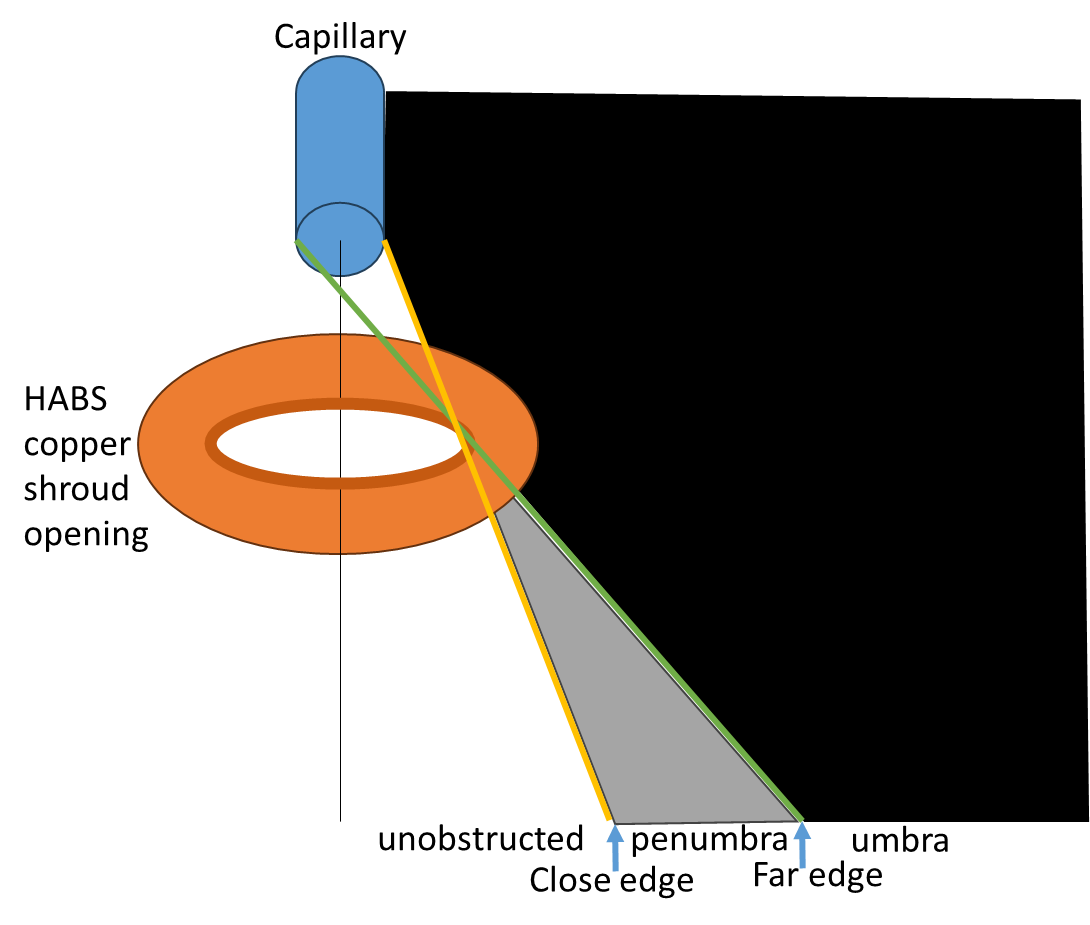

In [22]:
#2024-04-12 new version to be a real integral  over the capillary surface, and 

def theta_lims(radius_cap = 0.5, 
                      distance_cap_housing = 7.1, radius_housing = 3.0):
    
    ##### Adapted from beamfit.py

    # calculate fraction of the capillary that is visible under a
    # given angle
    # Presumes capillary to be centered on openning  in HABS housing
    # radius_cap = 0.5 # mm
    # distance_cap_housing = 7.1 # mm
    # radius_housing = 3.0 # mm

    # calculate edges of penumbra
    # inner (close) edge
    theta_inner = np.arctan((radius_housing - radius_cap)
                            /distance_cap_housing)
    theta_outer = np.arctan((radius_housing + radius_cap)
                            /distance_cap_housing)
    return (theta_inner, theta_outer)

def visible_fraction(theta, radius_cap = 0.5, 
                      distance_cap_housing = 7.1, radius_housing = 3.0):
    ##### Adapted from beamfit.py 
    (theta_inner, theta_outer) = theta_lims(radius_cap, 
                      distance_cap_housing, radius_housing)

    if np.abs(theta) <= theta_inner:
        fraction = 1
    elif np.abs(theta) >= theta_outer:
        fraction = 0
    else:
        # Take shortcut initially
        # HACK Linearly interpolate between inner and outer angles
        int_var = (2 *  ((theta_outer - np.abs(theta)) 
                    / (theta_outer - theta_inner))) - 1
        # Integrated circle equation
        vis_frac = lambda x: (np.sqrt(1-x**2) * x 
                                + np.arcsin(x)
                                + np.pi/2)/np.pi
        fraction = vis_frac(int_var)
    return fraction
    

### Plot extracted beam shape with l_eff and visible fraction

In [23]:
degree = np.pi/180
# remember to input values in radians
def beta(theta, l_eff):

    output = np.zeros_like(theta) 
    cond = np.abs(l_eff * np.tan(theta)) < 1
    output[cond] =  np.arccos(l_eff * np.tan(theta[cond]))
    return output


def U(theta, l_eff):
    # Move conditional to beta only
    return (2*beta(theta, l_eff)-np.sin(2*beta(theta, l_eff)))/np.pi

def V(theta, l_eff):
    # Move conditional to beta only
    return np.sin(beta(theta, l_eff))**3

def jd(theta, l_eff):
    return np.cos(theta) * U(theta, l_eff)

def jw(theta, l_eff):
    result = (
    (4/(3*np.pi))*(1-1/(2*l_eff + 1)) * (1/l_eff) 
    * (np.cos(theta)**2 / np.sin(theta)) 
    * (1-V(theta, l_eff))
    + (1/(2*l_eff + 1))*np.cos(theta) * (1-U(theta, l_eff))
    )
    return result

def j(theta, l_eff):
    return jd(theta, l_eff) + jw(theta, l_eff)

In [24]:
def new_H_profile(theta, l_eff, d_ch = 7.1):
    return j(theta, l_eff) * visible_fraction(theta,
                                               distance_cap_housing=d_ch)

### Plot H profile with error band

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


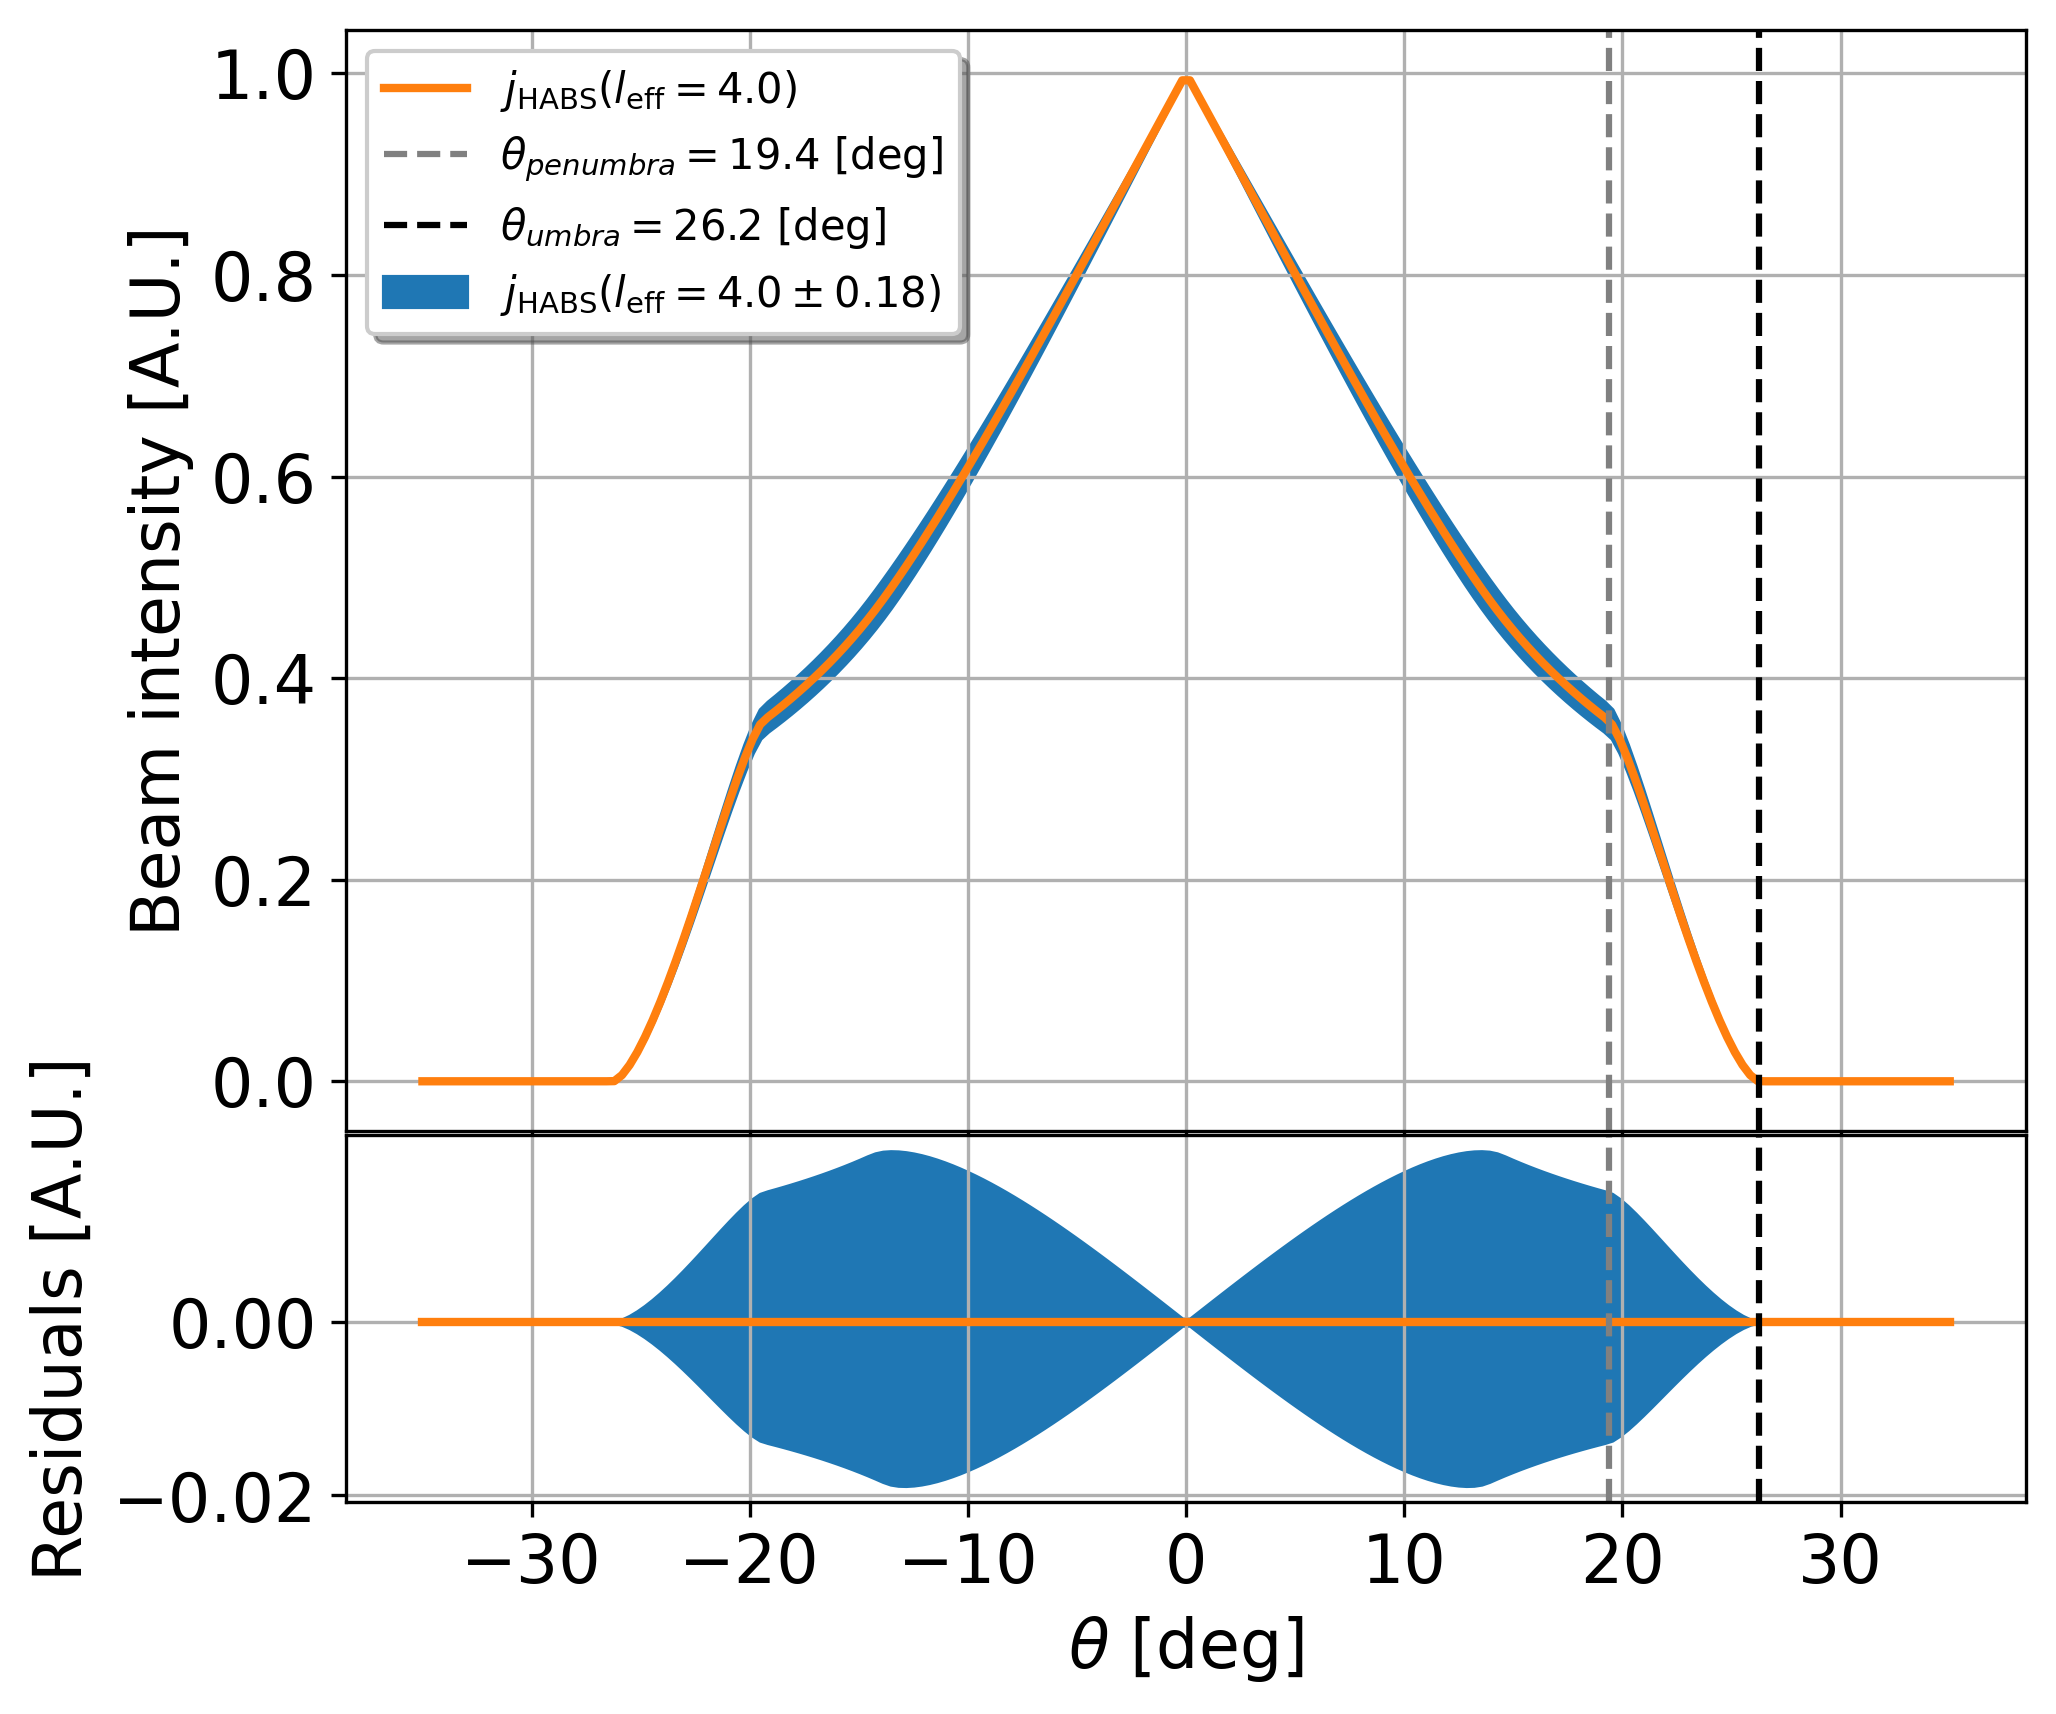

In [25]:
xs = np.linspace(-35,35, 200)
# ys = visible_fraction(xs * degree)
ys = np.array([new_H_profile(np.abs(x) * degree, l_eff = 4.0) for x in xs])
ys_high = np.array([new_H_profile(np.abs(x) * degree, l_eff = 4.0 +0.18) 
                    for x in xs])
ys_low = np.array(
    [new_H_profile(np.abs(x) * degree, l_eff = 4.0 -0.18) for x in xs]
                 ) 


fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
        )
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.fill_between(xs,ys_high,ys_low,
        color = "C0" ,label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0 \pm 0.18)$",
         #lw= 4
         )
ax1.plot(xs,ys,
        color = "C1" ,
        label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0)$",
         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.1f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.1f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U.]")

ax1.grid(True)
ax1.legend(shadow=True, fontsize="10")


ax2.fill_between(xs,ys_high - ys,ys_low-ys,
        color = "C0" ,label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0 \pm 0.18)$",
         #lw= 4
         )

ax2.plot(xs,ys-ys,
        color = "C1" ,
        label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0)$",
         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax2.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.1f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax2.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.1f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel(r"Residuals [A.U.]")

ax2.grid(True)




#make custom pruning of uppper tick (do not plot ticks in upper 10%)
#so that ax2 tick does nto interfere with  ax1 tick
ax2.locator_params(axis="y", min_n_ticks = 3
                    )
y_loc = ax2.yaxis.get_majorticklocs()
x_loc = ax1.xaxis.get_majorticklocs()
#print("y_loc: ", y_loc)
#print("y_loc[1:-2]: ", y_loc[1:-2])
#print("ylim: ", ax2.get_ylim())
y2_min, y2_max = ax2.get_ylim()
y_loc = [y for y in y_loc if y2_min < y < y2_max - (y2_max -
                                                     y2_min)*0.1]
#print("y_loc: ", y_loc)
ax2.set_yticks(y_loc)
# set  x lims:
x1_min, x1_max = ax1.get_xlim()
ax2.set_xticks(x_loc)
ax2.set_xlim(ax1.get_xlim())
# Delete xticks on 1st axis
ax1.set_xticklabels([])
fig.tight_layout()
fig.subplots_adjust(left=0.2)

### With values from new fit (2025-08-12)

In [26]:
#"('390TC', '0A')": {
popt  = [ 4.312883701356008,
            0.013843169732396044,
            1.5100816170783817,
            0.013724450889428348,
            7.508670776075118]
pcov  = [  [
                0.05020563795402979,
                -8.069324525314445e-05,
                0.0020795164574833776,
                0.0011924131741183467,
                0.0005101483723562397
            ],
            [
                -8.069324525314446e-05,
                1.9615648992850682e-07,
                -3.286425213783065e-06,
                -4.2125031163226295e-06,
                -1.7755409932043448e-05
            ],
            [
                0.0020795164574833784,
                -3.286425213783067e-06,
                0.016836520474559503,
                5.098505629091235e-06,
                0.010308594934920826
            ],
            [
                0.0011924131741183467,
                -4.2125031163226295e-06,
                5.0985056290912e-06,
                0.00013139233328422,
                0.0008673823392542823
            ],
            [
                0.0005101483723562404,
                -1.7755409932043445e-05,
                0.010308594934920826,
                0.0008673823392542823,
                0.05106228122636058
            ]
        ]
# and jsut for l_eff and dch:
popt_small = [popt[0], popt[4]]
pcov_small = [[pcov[0][0], pcov[0][4]],
              [pcov[4][0], pcov[4][4]]
               ]
print("pcov_small" , pcov_small)

pcov_small [[0.05020563795402979, 0.0005101483723562397], [0.0005101483723562404, 0.05106228122636058]]


In [27]:
popt[0]

4.312883701356008

In [28]:
l_eff = popt_small[0]
l_eff_err = np.sqrt(pcov[0][0])
d_ch = popt_small[1]
d_ch_err = np.sqrt(pcov[4][4])



c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


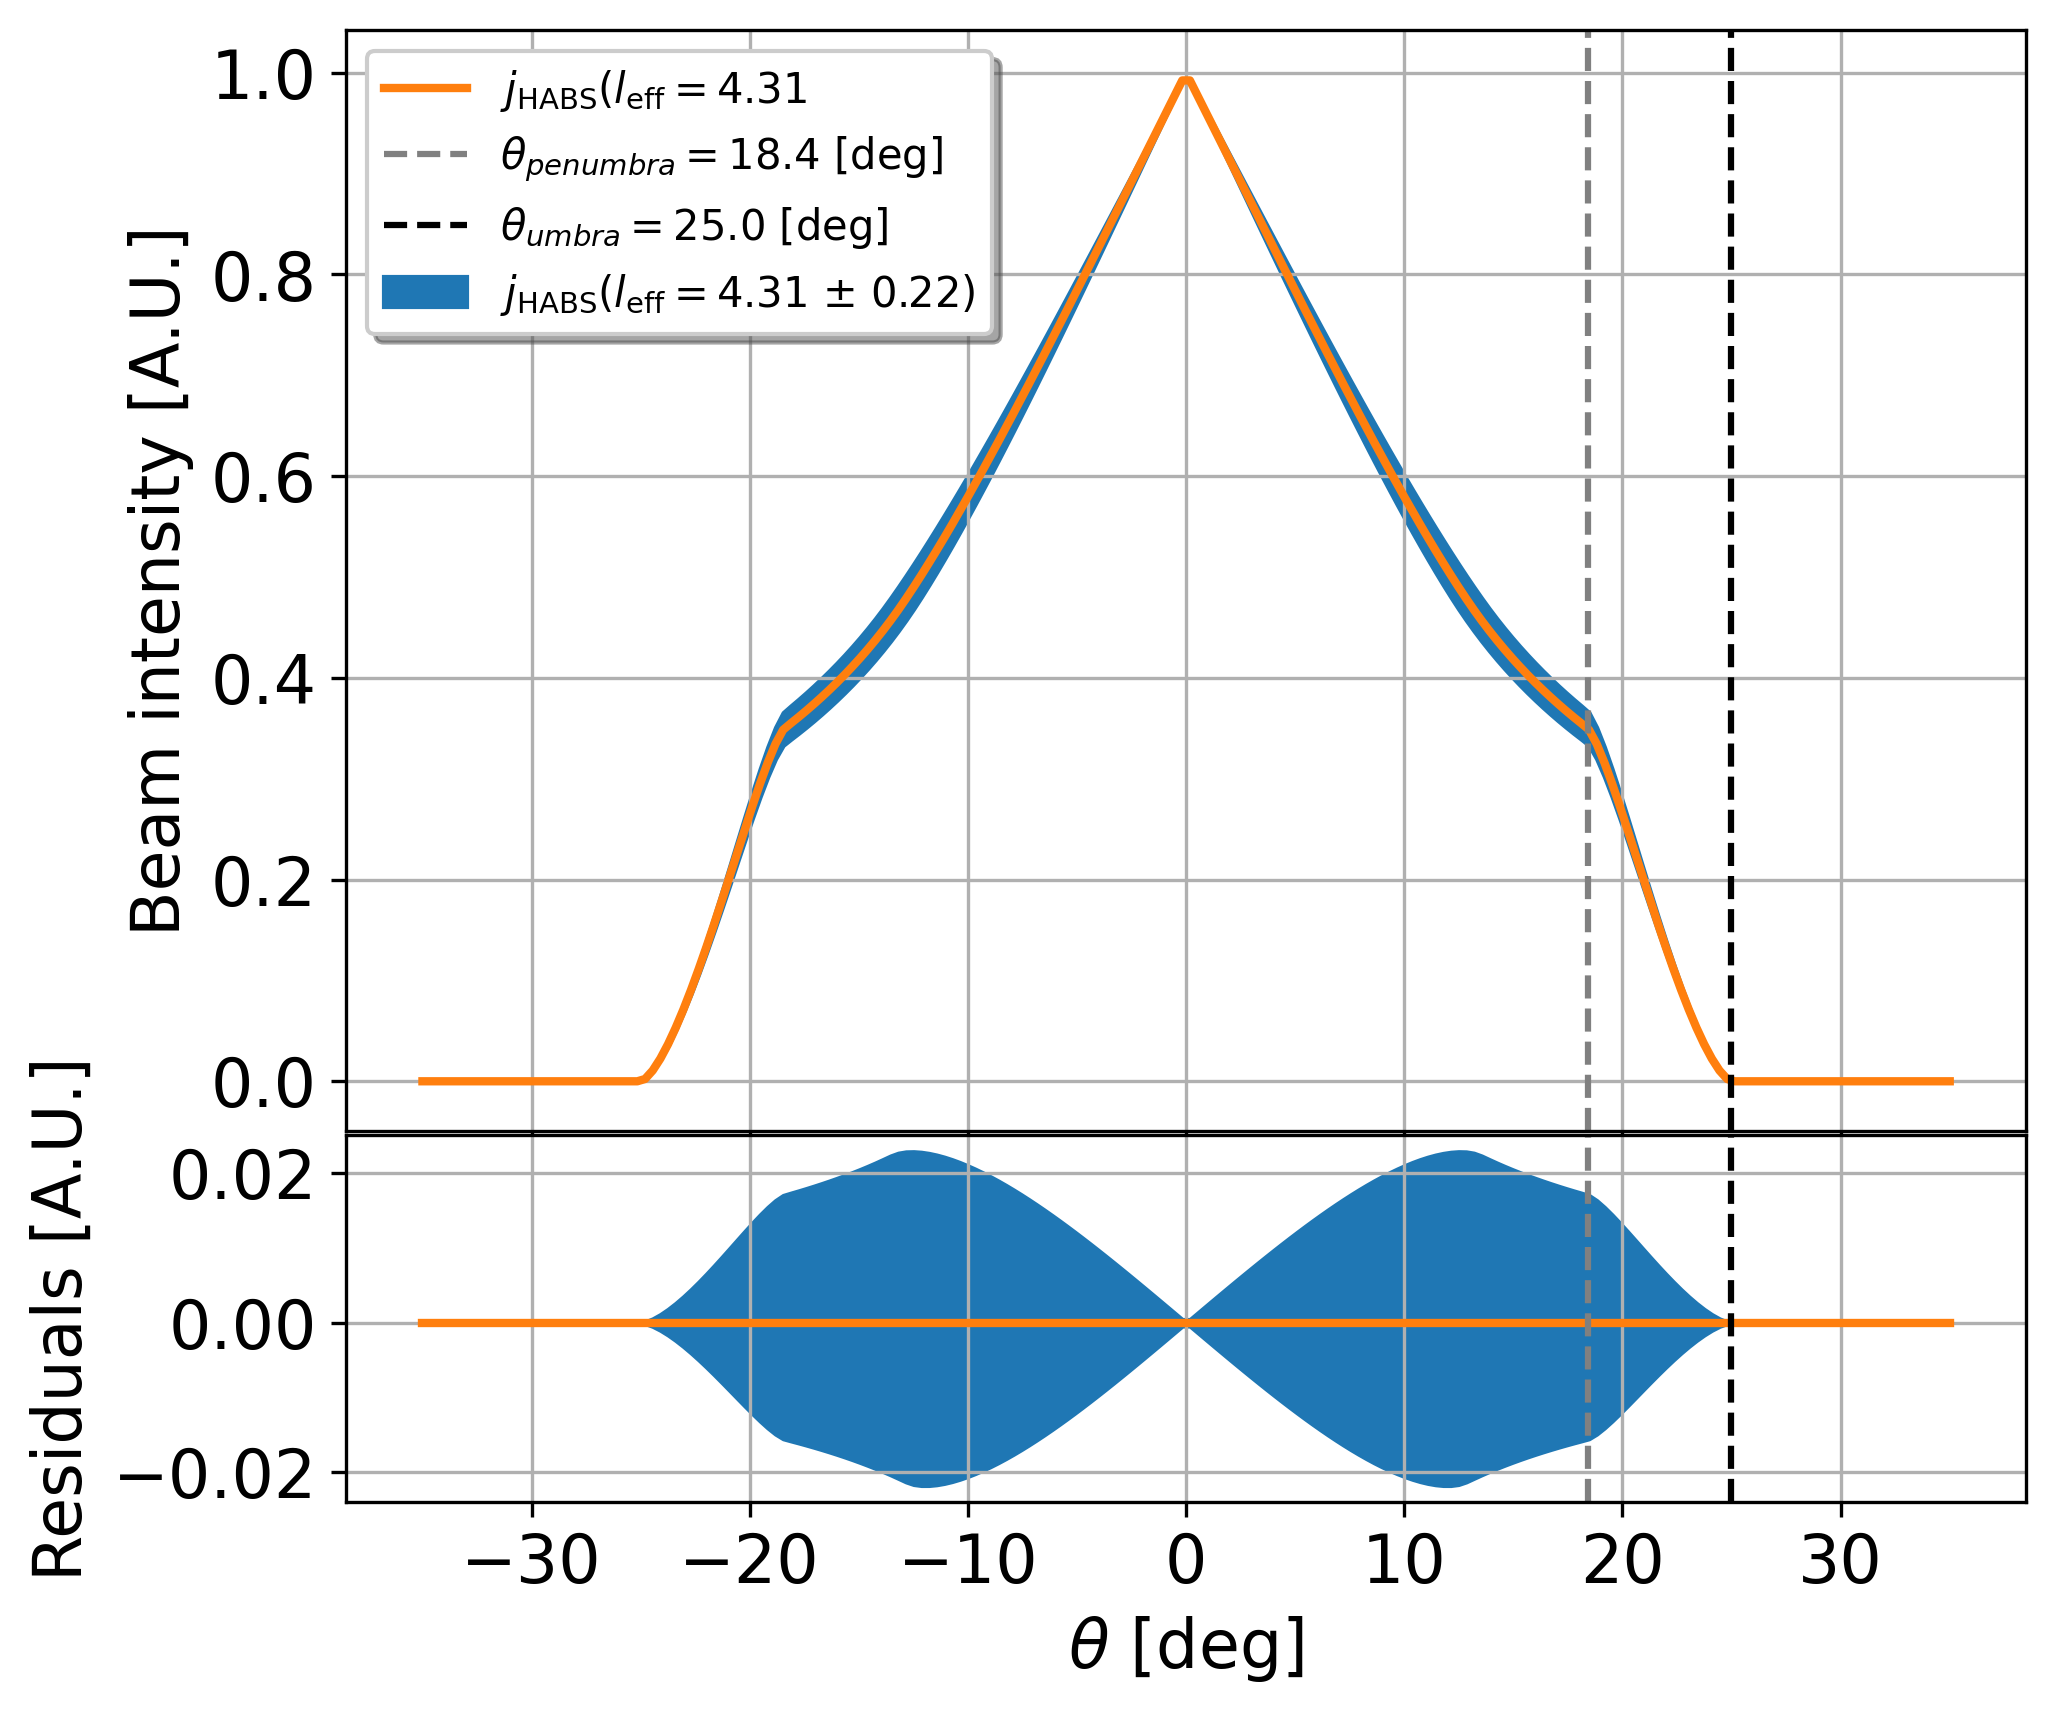

In [29]:

xs = np.linspace(-35,35, 200)
# ys = visible_fraction(xs * degree)
ys = np.array([new_H_profile(np.abs(x) * degree, l_eff = l_eff, 
                             d_ch= d_ch) for x in xs])
ys_high = np.array([new_H_profile(np.abs(x) * degree, 
                    l_eff = l_eff + l_eff_err, d_ch= d_ch) 
                    for x in xs])
ys_low = np.array(
    [new_H_profile(np.abs(x) * degree, l_eff = l_eff - l_eff_err, 
                   d_ch= d_ch) for x in xs]
                 ) 


fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
        )
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.fill_between(xs,ys_high,ys_low,
        color = "C0" ,label = (r"$j_{\rm{HABS}}(l_{\rm{eff}} =$"
                                + f"{l_eff:.2f} $\pm$ {l_eff_err:.2f})"),
         #lw= 4
         )
ax1.plot(xs,ys,
        color = "C1" ,
        label = (r"$j_{\rm{HABS}}(l_{\rm{eff}} =$"
                                + f"{l_eff:.2f}"),
         lw= 2)
theta_inner, theta_outer = theta_lims(distance_cap_housing=d_ch)
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.1f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.1f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U.]")

ax1.grid(True)
ax1.legend(shadow=True, fontsize="10")


ax2.fill_between(xs,ys_high - ys,ys_low-ys,
        color = "C0" ,#label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0 \pm 0.18)$",
         #lw= 4
         )

ax2.plot(xs,ys-ys,
        color = "C1" ,
        #label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0)$",
         lw= 2)
ax2.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.1f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax2.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.1f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel(r"Residuals [A.U.]")

ax2.grid(True)




#make custom pruning of uppper tick (do not plot ticks in upper 10%)
#so that ax2 tick does nto interfere with  ax1 tick
ax2.locator_params(axis="y", min_n_ticks = 3
                    )
y_loc = ax2.yaxis.get_majorticklocs()
x_loc = ax1.xaxis.get_majorticklocs()
#print("y_loc: ", y_loc)
#print("y_loc[1:-2]: ", y_loc[1:-2])
#print("ylim: ", ax2.get_ylim())
y2_min, y2_max = ax2.get_ylim()
y_loc = [y for y in y_loc if y2_min < y < y2_max - (y2_max -
                                                     y2_min)*0.1]
#print("y_loc: ", y_loc)
ax2.set_yticks(y_loc)
# set  x lims:
x1_min, x1_max = ax1.get_xlim()
ax2.set_xticks(x_loc)
ax2.set_xlim(ax1.get_xlim())
# Delete xticks on 1st axis
ax1.set_xticklabels([])
fig.tight_layout()
fig.subplots_adjust(left=0.2)

Usinng Jacobi

In [30]:
from jacobi import propagate


In [31]:
def model(x, par):
    return new_H_profile(np.abs(x) * degree, l_eff = par[0], 
                             d_ch= par[1])

In [32]:
# values = popt_small
# covariance = pcov_small
# errors = [np.sqrt(covariance[i][i]) for i in range(len(values))]
# # run error propagation
# y, ycov = propagate(lambda p: model(xs, p)[1], values, covariance)

# # # plot everything
# # plt.errorbar(xs, d, derr, fmt="o", label="data", zorder=0)

# plt.plot(xs, y, lw=3, label="fit")

# # draw 1 sigma error band
# yerr_prop = np.diag(ycov) ** 0.5
# plt.fill_between(xs, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)

# plt.legend(
#     frameon=False,
#     title=f"$n = {values[0]:.2f} +/- {errors[0]:.2f}$\n"
#     f"$\\mu = {values[1]:.2f} +/- {errors[1]:.2f}$\n",
# );

Manually Propagating errorband

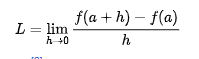

In [33]:
#Define numerical derivatives
def model(x, par):
    return new_H_profile(np.abs(x) * degree, l_eff = par[0], 
                             d_ch= par[1])

h = 0.0001
def dH_dl(x, par):
    return (new_H_profile(np.abs(x) * degree, l_eff = par[0], 
                             d_ch= par[1]) 
    - new_H_profile(np.abs(x) * degree, l_eff = par[0] + h, 
                             d_ch= par[1])) / h  

def dH_ddch(x, par):
    return (new_H_profile(np.abs(x) * degree, l_eff = par[0], 
                             d_ch= par[1]) 
    - new_H_profile(np.abs(x) * degree, l_eff = par[0], 
                             d_ch= par[1] + h)) / h 

In [34]:
# define error band function

delta_l = lambda x, par, pcov: np.sqrt(
    dH_dl(x, par)**2 * pcov[0][0]
    + dH_ddch(x, par)**2 * pcov[1][1]
    # and covariance term (s) (counted twice due to symmetry)
    + 2* dH_dl(x, par) * dH_ddch(x, par)
       * pcov[0][1])

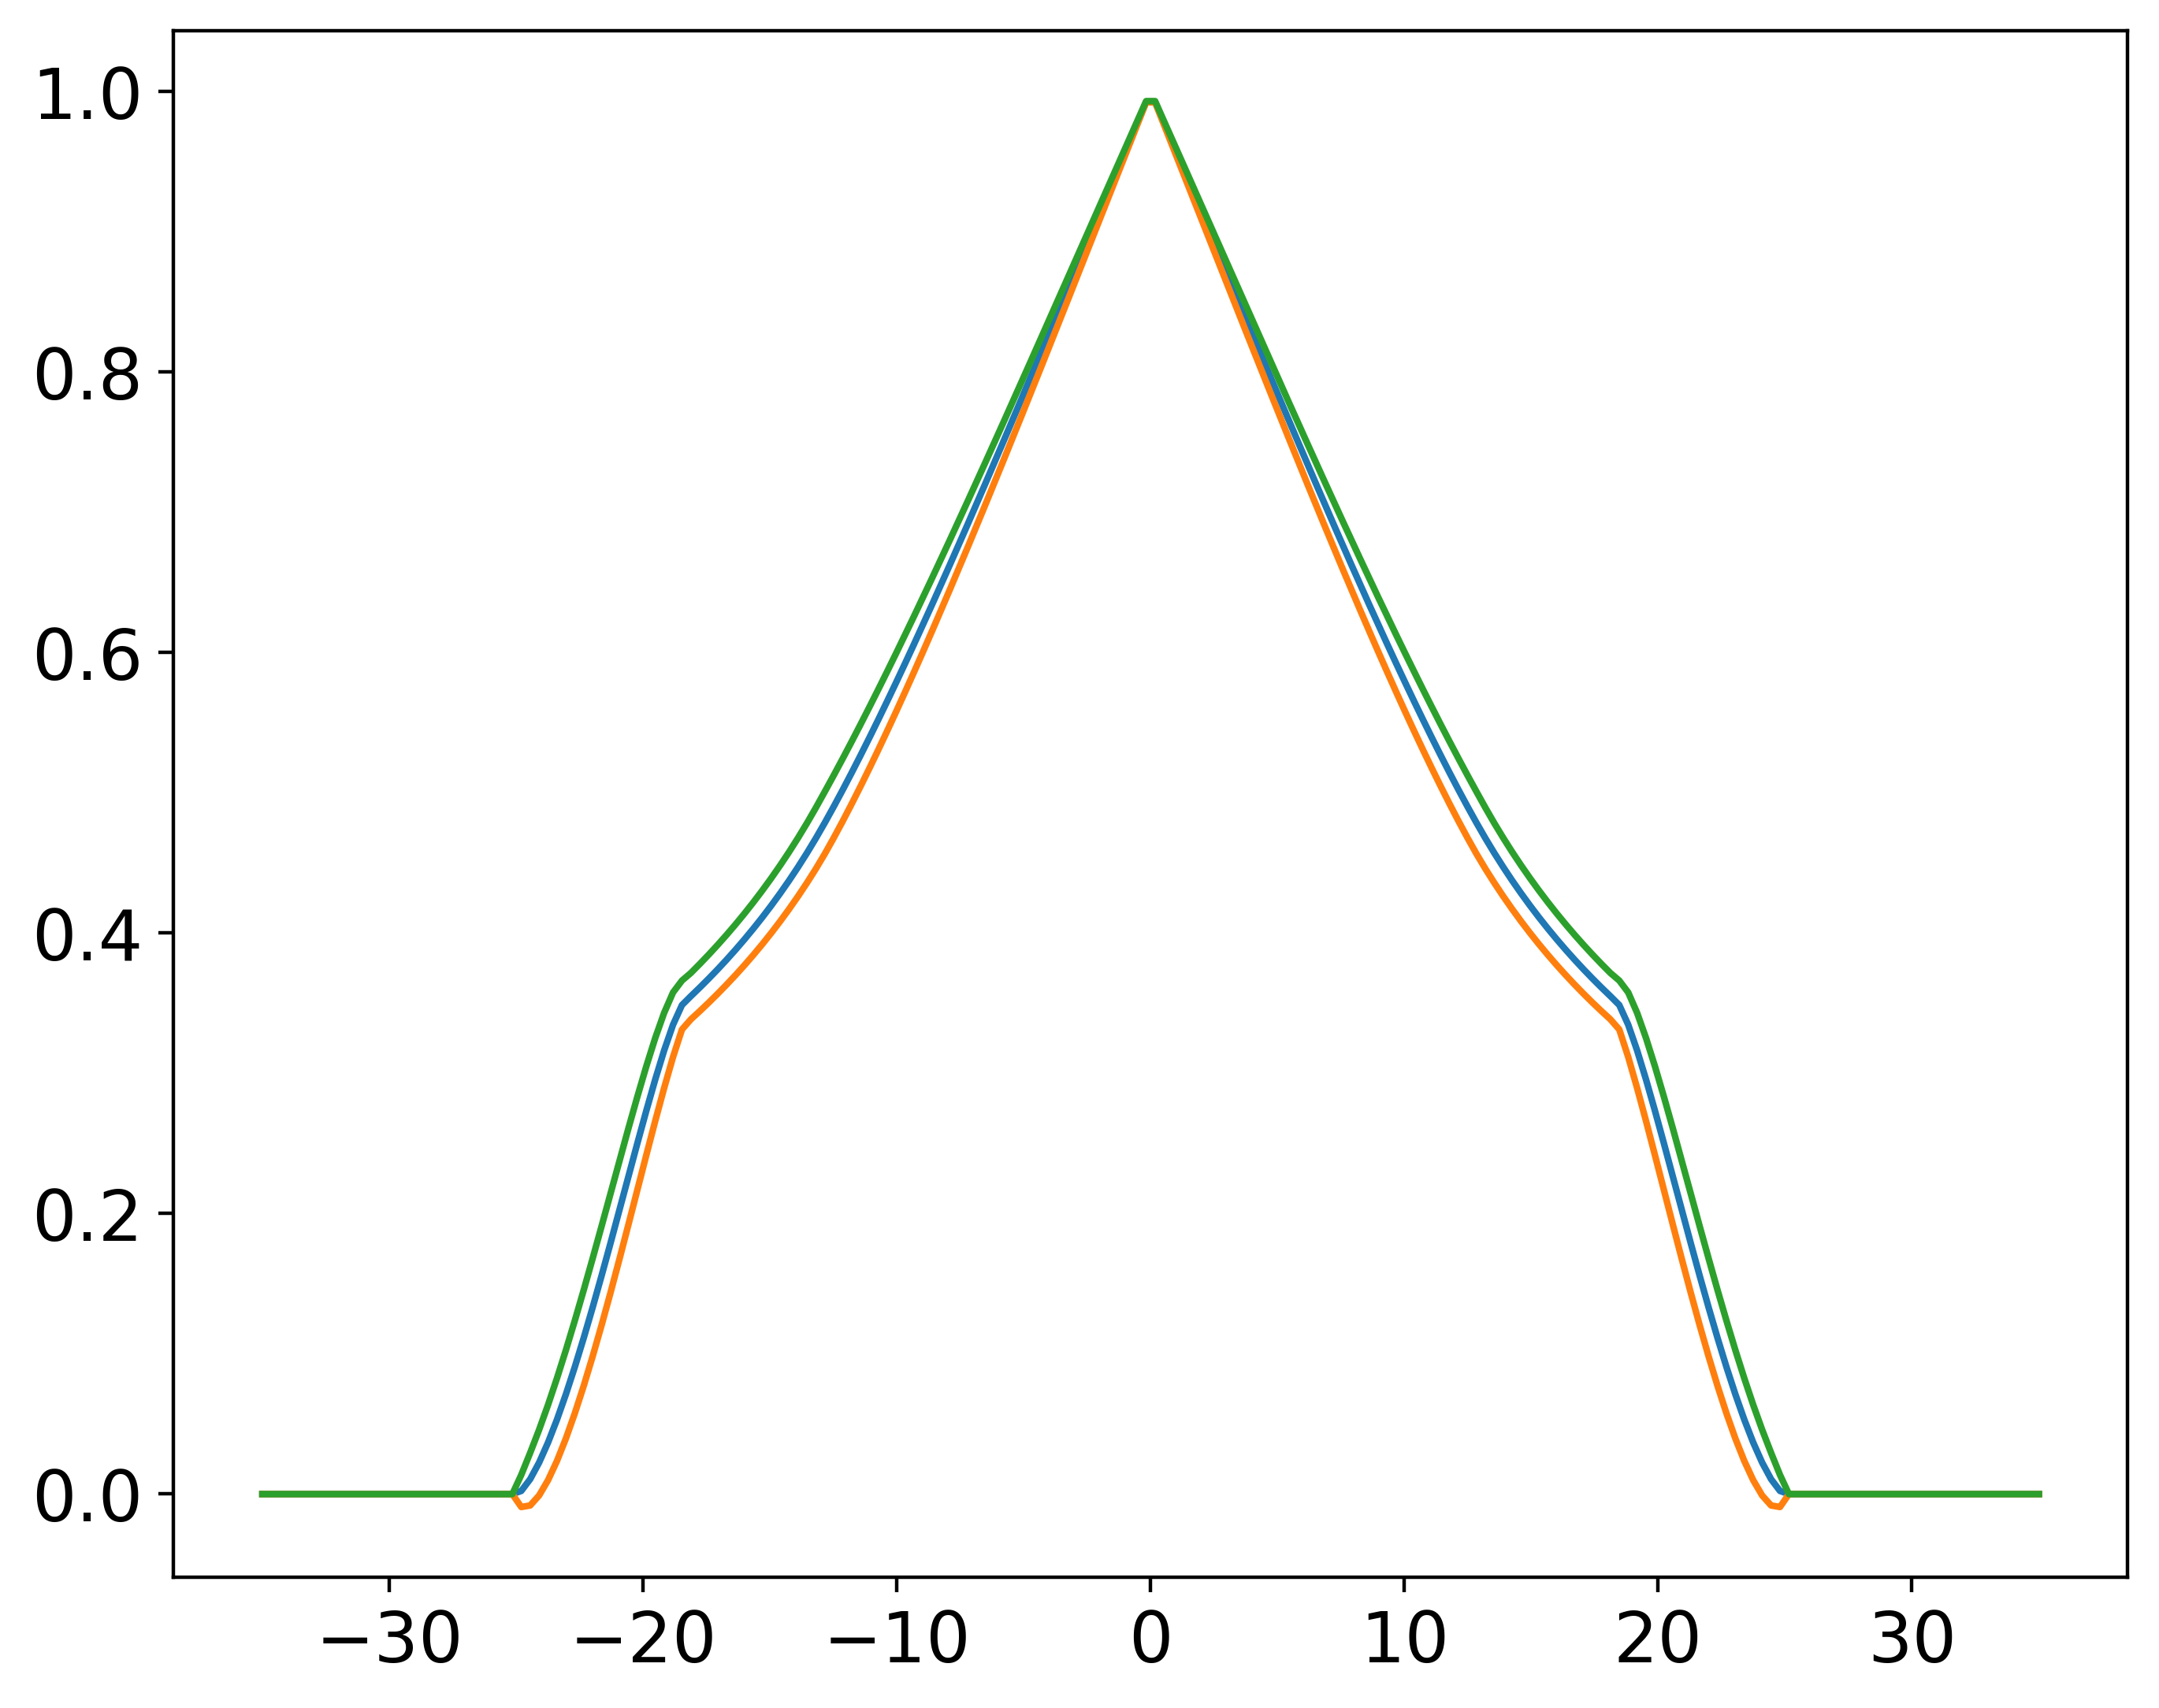

In [35]:
plt.figure(figsize=(8,6.5))

par = popt_small
pcov_small

base =[model(x, par) for x in xs] 
low = [model(x, par) - delta_l(x, popt_small, pcov_small) for x in xs]
high = [model(x, par) + delta_l(x, popt_small, pcov_small) for x in xs]

plt.plot(xs, base, label = "λ_fit")
plt.plot(xs, low, label = "λ_-")
plt.plot(xs, high, label = "λ_+")

Try for maximally correlated errors with angle range

In [36]:
d_ch_err, l_eff_err

(0.22596964669256042, 0.2240661463809957)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


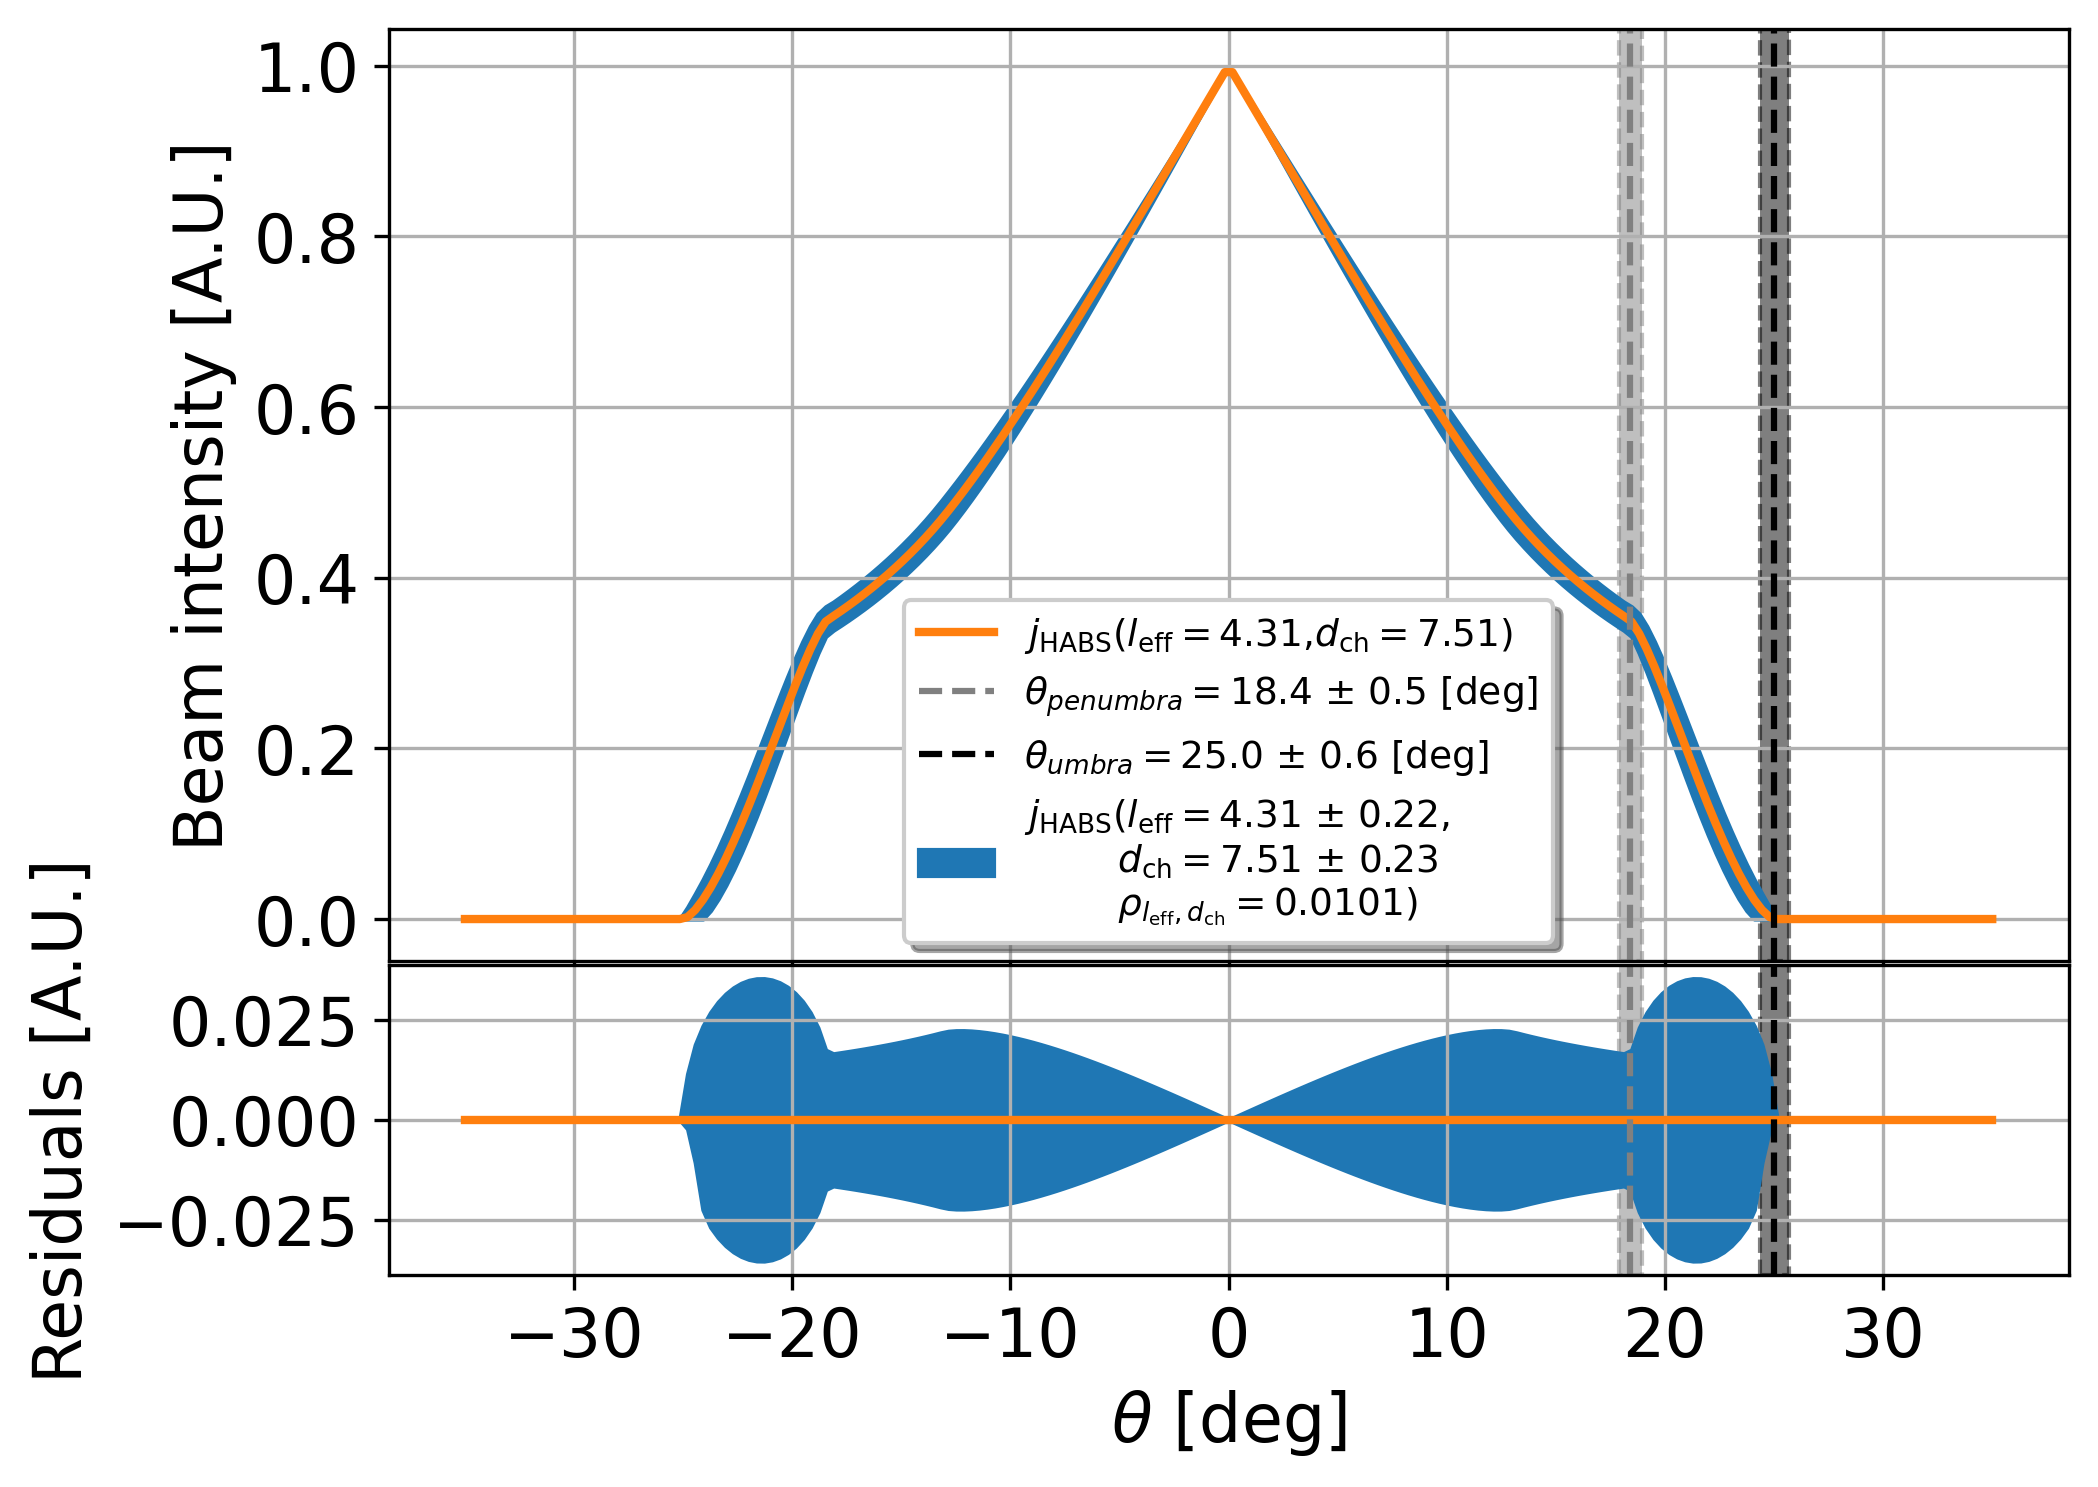

In [48]:

xs = np.linspace(-35,35, 200)

par = popt_small
pcov_small

ys = np.array([model(x, par) for x in xs]) 
# ys_low = np.array([model(x, par) - delta_l(x, popt_small, pcov_small)
#                     for x in xs])

# ys_low = np.array([model(x, np.array(par) + np.array([-l_eff_err, -d_ch_err]))
#                    for x in xs])

# #(Values below 0 are not  physically relevant)
# # Replacing all negative values in the array 'x' with 0 using boolean indexing
# # ys_low[ys_low < 0] = 0
# # ys_high = np.array([model(x, par) + delta_l(x, popt_small, pcov_small)
# #                      for x in xs])
# ys_high = np.array([model(x, np.array(par) + np.array([l_eff_err,  d_ch_err]))
#                    for x in xs])

#Attempt with correlation:
ys_low = np.array(
        [model(x, par) - delta_l(x, popt_small, pcov_small)
         if (model(x, par) - delta_l(x, popt_small, pcov_small))> 0 
         else 0
         for x in xs]
         )
ys_high = np.array(
    [model(x, par) + delta_l(x, popt_small, pcov_small) for x in xs]
        )   



fig = plt.figure(0, figsize=(8,5.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
        )
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

corr_coeff = pcov_small[0][1]/(
                        np.sqrt(pcov[0][0]*pcov_small[1][1]))
ax1.fill_between(xs,ys_high,ys_low,
        color = "C0" ,label = (r"$j_{\rm{HABS}}(l_{\rm{eff}} =$"
                                + f"{l_eff:.2f} $\pm$ {l_eff_err:.2f},\n"
                                + r"$\quad \quad \: \,\, d_{\rm ch} = $" 
                                + f"{d_ch:.2f} $\pm$ {d_ch_err:.2f} \n"
                                + r"$\quad \quad \: \,\,$"
                                + r"$\rho_{l_{\rm{eff}}, d_{\rm{ch}}}$" 
                                + f"$= {corr_coeff:.2f}$"
                                +")"
                                ),
         #lw= 4
         )
ax1.plot(xs,ys,
        color = "C1" ,
        label = (r"$j_{\rm{HABS}}(l_{\rm{eff}} =$"
                                + f"{l_eff:.2f},"
                    + r"$d_{\rm{ch}} =$" + f"{d_ch:.2f}" 
                    + ")"
                                ),
         lw= 2)
theta_inner, theta_outer = theta_lims(distance_cap_housing=d_ch)
theta_inner_min, theta_outer_min = theta_lims(
                    distance_cap_housing = d_ch + d_ch_err )
theta_inner_max, theta_outer_max = theta_lims(
                    distance_cap_housing = d_ch - d_ch_err )

ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.1f} $\pm$ " 
        + f"{(theta_inner - theta_inner_min)/degree:.1f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvspan(theta_inner_min/degree, theta_inner_max/degree, 
            #label=r"2211K-1277K-298K,  " + r"$l_{\rm eff} = $"
        #+ f"{l_eff:.2f}" + r"$\pm$" + f"{err:.2f}", 
        color = "gray", alpha = 0.5, ls = "--",  zorder =0 )


ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.1f} $\pm$ " 
        + f"{(theta_outer - theta_outer_min)/degree:.1f} [deg]", 
        color = "k", alpha = 1, ls = "--")
ax1.axvspan(theta_outer_min/degree, theta_outer_max/degree, 
            #label=r"2211K-1277K-298K,  " + r"$l_{\rm eff} = $"
        #+ f"{l_eff:.2f}" + r"$\pm$" + f"{err:.2f}", 
        color = "k", alpha = 0.5, ls = "--", zorder =0 )


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U.]")

ax1.grid(True)
ax1.legend(shadow=True, fontsize=9)


ax2.fill_between(xs,ys_high - ys,ys_low-ys,
        color = "C0" ,#label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0 \pm 0.18)$",
         #lw= 4
         )

ax2.plot(xs,ys-ys,
        color = "C1" ,
        #label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0)$",
         lw= 2)
ax2.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.1f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax2.axvspan(theta_inner_min/degree, theta_inner_max/degree, 
            #label=r"2211K-1277K-298K,  " + r"$l_{\rm eff} = $"
        #+ f"{l_eff:.2f}" + r"$\pm$" + f"{err:.2f}", 
        color = "gray", alpha = 0.5, ls = "--",  zorder =0 )


ax2.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.1f} [deg]", 
        color = "k", alpha = 1, ls = "--")
ax2.axvspan(theta_outer_min/degree, theta_outer_max/degree, 
            #label=r"2211K-1277K-298K,  " + r"$l_{\rm eff} = $"
        #+ f"{l_eff:.2f}" + r"$\pm$" + f"{err:.2f}", 
        color = "k", alpha = 0.5, ls = "--", zorder =0 )


ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel(r"Residuals [A.U.]")

ax2.grid(True)




#make custom pruning of uppper tick (do not plot ticks in upper 10%)
#so that ax2 tick does nto interfere with  ax1 tick
ax2.locator_params(axis="y", min_n_ticks = 3
                    )
y_loc = ax2.yaxis.get_majorticklocs()
x_loc = ax1.xaxis.get_majorticklocs()
#print("y_loc: ", y_loc)
#print("y_loc[1:-2]: ", y_loc[1:-2])
#print("ylim: ", ax2.get_ylim())
y2_min, y2_max = ax2.get_ylim()
y_loc = [y for y in y_loc if y2_min < y < y2_max - (y2_max -
                                                     y2_min)*0.1]
#print("y_loc: ", y_loc)
ax2.set_yticks(y_loc)
# set  x lims:
x1_min, x1_max = ax1.get_xlim()
ax2.set_xticks(x_loc)
ax2.set_xlim(ax1.get_xlim())
# Delete xticks on 1st axis
ax1.set_xticklabels([])
fig.tight_layout()
fig.subplots_adjust(left=0.2)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


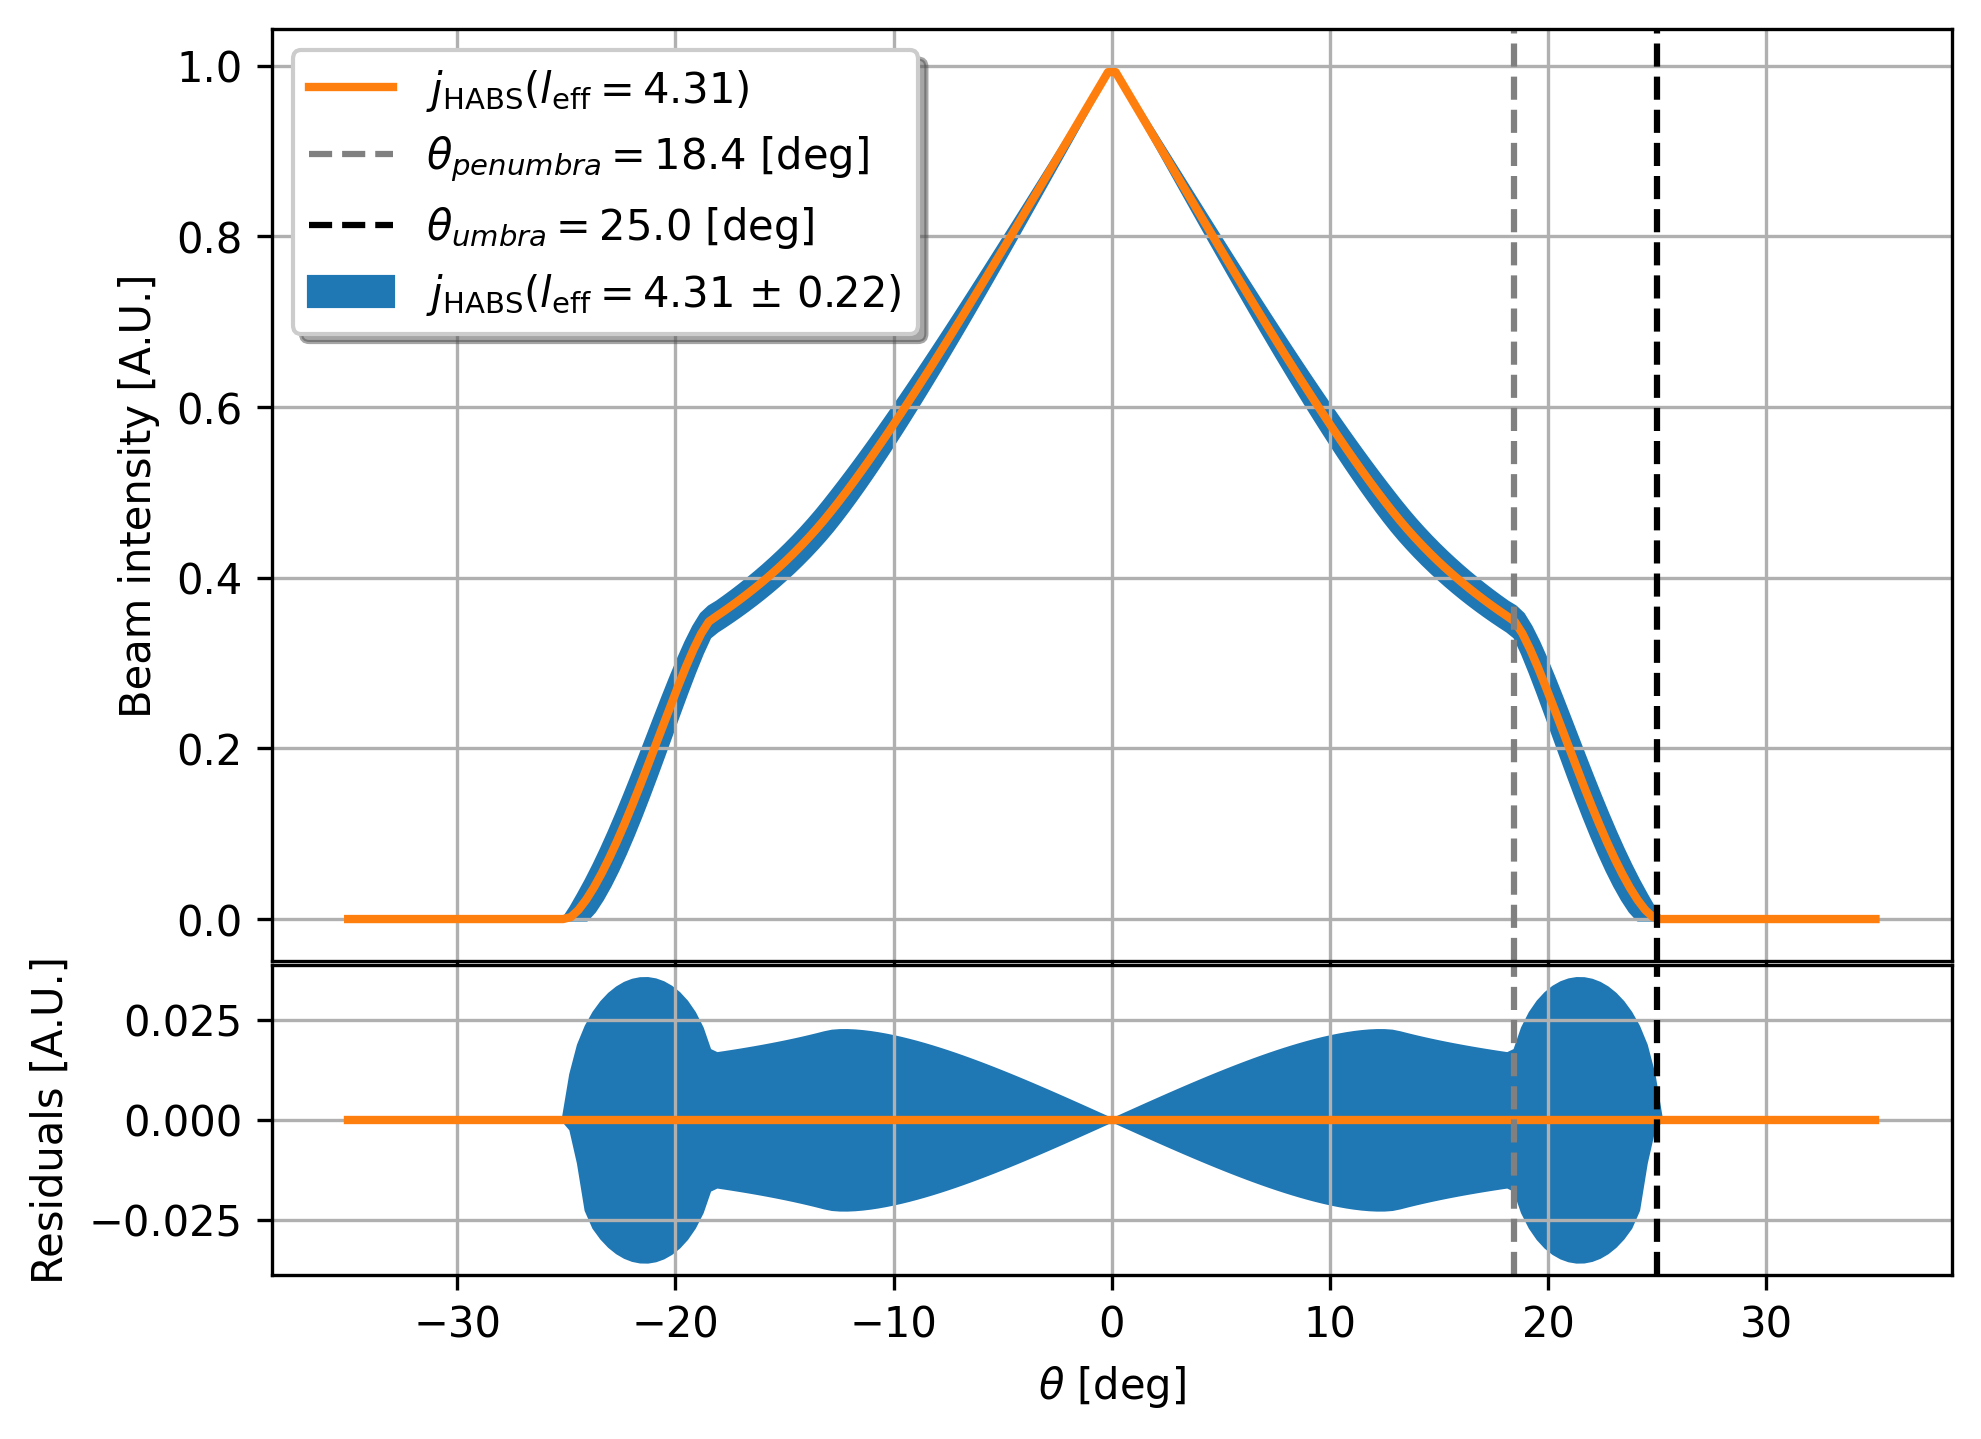

In [ ]:

xs = np.linspace(-35,35, 200)

par = popt_small
pcov_small

ys = np.array([model(x, par) for x in xs]) 
ys_low = np.array([model(x, par) - delta_l(x, popt_small, pcov_small)
                    for x in xs])
#(Values below 0 are not  physically relevant)
# Replacing all negative values in the array 'x' with 0 using boolean indexing
ys_low[ys_low < 0] = 0
ys_high = np.array([model(x, par) + delta_l(x, popt_small, pcov_small)
                     for x in xs])


fig = plt.figure(0, figsize=(8,5.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
        )
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.fill_between(xs,ys_high,ys_low,
        color = "C0" ,label = (r"$j_{\rm{HABS}}(l_{\rm{eff}} =$"
                                + f"{l_eff:.2f} $\pm$ {l_eff_err:.2f})"),
         #lw= 4
         )
ax1.plot(xs,ys,
        color = "C1" ,
        label = (r"$j_{\rm{HABS}}(l_{\rm{eff}} =$"
                                + f"{l_eff:.2f})"),
         lw= 2)
theta_inner, theta_outer = theta_lims(distance_cap_housing=d_ch)

ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.1f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.1f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U.]")

ax1.grid(True)
ax1.legend(shadow=True, fontsize="10")


ax2.fill_between(xs,ys_high - ys,ys_low-ys,
        color = "C0" ,#label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0 \pm 0.18)$",
         #lw= 4
         )

ax2.plot(xs,ys-ys,
        color = "C1" ,
        #label = r"$j_{\rm{HABS}}(l_{\rm{eff}} = 4.0)$",
         lw= 2)
ax2.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.1f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax2.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.1f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel(r"Residuals [A.U.]")

ax2.grid(True)




#make custom pruning of uppper tick (do not plot ticks in upper 10%)
#so that ax2 tick does nto interfere with  ax1 tick
ax2.locator_params(axis="y", min_n_ticks = 3
                    )
y_loc = ax2.yaxis.get_majorticklocs()
x_loc = ax1.xaxis.get_majorticklocs()
#print("y_loc: ", y_loc)
#print("y_loc[1:-2]: ", y_loc[1:-2])
#print("ylim: ", ax2.get_ylim())
y2_min, y2_max = ax2.get_ylim()
y_loc = [y for y in y_loc if y2_min < y < y2_max - (y2_max -
                                                     y2_min)*0.1]
#print("y_loc: ", y_loc)
ax2.set_yticks(y_loc)
# set  x lims:
x1_min, x1_max = ax1.get_xlim()
ax2.set_xticks(x_loc)
ax2.set_xlim(ax1.get_xlim())
# Delete xticks on 1st axis
ax1.set_xticklabels([])
fig.tight_layout()
fig.subplots_adjust(left=0.2)